In [1]:
import numpy as np
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact

from IPython import display

import os

%matplotlib inline

In [2]:
from joblib import Parallel, delayed
import multiprocessing
      
num_cores = multiprocessing.cpu_count()

In [3]:
from model.minee import MINEE
from data.gaussian import Gaussian

In [4]:
np.random.seed(0)
torch.manual_seed(0)

## Data

In [5]:
def gen_data(rho, sample_size, d):
#     sample_size = 400
#     rho = 0.9
    rep = 1 # number of repeated runs
#     d = 6
    X = np.zeros((rep,sample_size,d))
    Y = np.zeros((rep,sample_size,d))
    for i in range(rep):
        for j in range(d):
            data = Gaussian(sample_size=sample_size,rho=rho).data
            X[i,:,j] = data[:,0]
            Y[i,:,j] = data[:,1]
    return X, Y, rep

In [6]:
def plot(d, X, Y):
    plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Plot of data samples with dimension %s' % d)
    plt.show()

In [7]:
def init_model(X, Y, batch_size, ref_batch_factor, lr):
    minee_list = []
    for i in range(rep):
        minee_list.append(MINEE(torch.Tensor(X[i]),torch.Tensor(Y[i]),batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr))
    dXY_list = np.zeros((rep,0))
    dX_list = np.zeros((rep,0))
    dY_list = np.zeros((rep,0))
    return minee_list, dXY_list, dX_list, dY_list

In [8]:
def load_model(chkpt_name, minee_list, dXY_list, dX_list, dY_list):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    dX_list = checkpoint['dX_list']
    dY_list = checkpoint['dY_list']
    minee_state_list = checkpoint['minee_state_list']
    for i in range(rep):
        minee_list[i].load_state_dict(minee_state_list[i])
    return checkpoint, minee_state_list, minee_list, dXY_list, dX_list, dY_list

In [9]:
def train_model(rho, sample_size, ref_batch_factor, d, minee_list, dXY_list, dX_list, dY_list):
    #run 6000 iterations
    for k in range(10):
        for j in range(600):
            dXY_list = np.append(dXY_list, np.zeros((rep, 1)), axis=1)
            dX_list = np.append(dX_list, np.zeros((rep, 1)), axis=1)
            dY_list = np.append(dY_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                minee_list[i].step()
                dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_list[i].forward()
        # To show intermediate works
        for i in range(rep):
            plt.title('Rho %s Sample/Batch Size %s Ref Batch Factor %s Dim %s MINEE' % (rho, sample_size, ref_batch_factor, d))
            plt.plot(dXY_list[i, :])
            plt.plot(dX_list[i, :])
            plt.plot(dY_list[i, :])
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()
    minee_state_list = [minee_list[i].state_dict() for i in range(rep)]
    return minee_state_list, minee_list, dXY_list, dX_list, dY_list

In [10]:
def save_model(dXY_list, dX_list, dY_list, minee_state_list, chkpt_name):
    torch.save({
        'dXY_list': dXY_list,
        'dX_list': dX_list,
        'dY_list': dY_list,
        'minee_state_list': minee_state_list
    }, chkpt_name)

In [11]:
def plot_mi(dXY_list, dX_list, dY_list, mi):
    ma_rate = 0.01
    mi_list = (dXY_list-dX_list-dY_list).copy()
    for i in range(1,dXY_list.shape[1]):
        mi_list[:,i] = (1-ma_rate) * mi_list[:,i-1] + ma_rate * mi_list[:,i]
    for i in range(rep):
        plt.plot(mi_list[i,:])
    plt.axhline(mi)
    plt.title("Plot of MI estimates against number of iterations")
    plt.xlabel("number of iterations")
    plt.ylabel("MI estimate")
    plt.savefig(fig_name)

## Analysis

In [12]:
dims = [2, 4, 6, 8, 10]
ratios = [25, 37.5, 50, 62.5, 75, 87.5, 100]

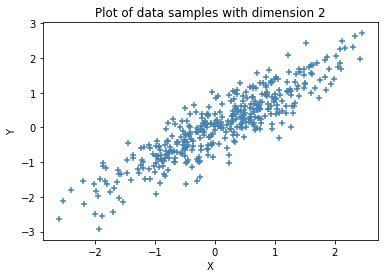

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

In [14]:
rho = 0.9
sample_size = 400
for d in dims:
    X, Y, rep = gen_data(rho = rho, sample_size = sample_size, d = d)
    #Plot function
    plot(d, X, Y)
    for ratio in ratios:
        batch_size = int(sample_size*1)
        ref_batch_factor = d*ratio
        lr = 1e-4
        # Define name
        name = ('G%s_ssbs%s_rbf%s_d%s_MINEE' % (rho, sample_size, ref_batch_factor, d))
        chkpt_name = name+'.pt'
        fig_name = name+'.pdf'

        minee_list, dXY_list, dX_list, dY_list = init_model(X, Y, batch_size, ref_batch_factor, lr)

        mi = - 0.5 * np.log(1-rho **2) * d
        print('MI is %s for dim %s and rbf %s' % (mi, d, ref_batch_factor))

        load_available = True
        if load_available and os.path.exists(chkpt_name):
            checkpoint, minee_state_list, minee_list, dXY_list, dX_list, dY_list = load_model(chkpt_name, minee_list, dXY_list, dX_list, dY_list)
            print(dXY_list, dX_list, dY_list)
        else: 
            minee_state_list, minee_list, dXY_list, dX_list, dY_list = train_model(rho, sample_size, ref_batch_factor, d, minee_list, dXY_list, dX_list, dY_list)
            save_model(dXY_list, dX_list, dY_list, minee_state_list, chkpt_name)

        plot_mi(dXY_list, dX_list, dY_list, mi)